In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import operator
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from itertools import product


# Set 
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 15

#visualize all the columns in pandas-->BIG TABLES
pd.set_option('display.max_columns', None)

# Individuals from NHANES with covariates 

In [2]:
pathdir='./input_data/'
tablecov=pd.read_csv(pathdir+'nhanesDesign_RAW_ALL_dataset_caloric_intake_PSJ1_58_nuts_temp_cohort_all.csv')
resultcov = pd.merge(tablecov.loc[:, 'SEQN':'education'], tablecov.loc[:, 'metabolic.syndrome.only.examination':'WTMEC8YR'],left_index=True, right_index=True)
resultcov['num_unique_dishes']=tablecov['num_unique_dishes']

# Effect sizes of potential interest
#Arthritis
resultcov['ever_arthritis']=tablecov.ever_arthritis
#Heart attack or Angina
resultcov['any_family_cad']=tablecov.any_family_cad
#cancer
resultcov['any_cancer_self_report']=tablecov.any_cancer_self_report
#Trunk Fat
resultcov['DXXTRFAT']=tablecov.DXXTRFAT
#Bone Mineral Density
resultcov['DXDTOBMD']=tablecov.DXDTOBMD
#Vitamins
resultcov['LBXB12']=tablecov.LBXB12
resultcov['LBXVIC']=tablecov.LBXVIC
resultcov['LBXVID']=tablecov.LBXVID
resultcov['LBXVIE']=tablecov.LBXVIE
#Contaminants
resultcov['URXBPH']=tablecov.URXBPH
resultcov['LBXVTO']=tablecov.LBXVTO

In [3]:
# filter to get the cohort with 18+, with statistical weights, and dietary records that led to food processing score
filterpeople=((resultcov.age>=18)&(resultcov.WTMEC8YR>0)&(resultcov['ens_FPro.WCDPI.mean.of.both.days.sum']>0))
print('Number of individuals in the epidemiological analysis')
print(sum(filterpeople))

Number of individuals in the epidemiological analysis
20047


# FNDDS Food Databases for 2001-2003-2005

In [4]:
tablefoodyear=pd.read_csv(pathdir+'FNDDS_1999_2006_Weighted_Consumption_WWEIA_nuts_FPro.csv')
tablefoodyear.drop(columns='Unnamed: 0', inplace=True)

/Users/giulia/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Check Food Classification
# switch 'Not included in a food category' to NaN ...you don't want them in the food substitution algorithm
tablefoodyear.loc[tablefoodyear['WWEIA Category description']=='Not included in a food category', 'WWEIA Category description']=np.nan

# Dietary Patterns 

In [6]:
# import the food records
tablepeoplefood=pd.read_csv(pathdir+'NHANES_1999_2006_all_individual_foods.csv')
tablepeoplefood.drop(columns='Unnamed: 0', inplace=True)

# Food records for the Epidemiological Analysis

In [7]:
tablepeoplefoodEWAS=tablepeoplefood[tablepeoplefood['SEQN'].isin(resultcov[filterpeople].SEQN)]

In [8]:
# table characterizing the records for each person
consumptionnumbers=tablepeoplefoodEWAS[tablepeoplefoodEWAS['Removed water']==0].groupby('SEQN').agg(NumRecords=pd.NamedAgg(column='Food code', aggfunc='count'),
                                                                       UniqueFoods=pd.NamedAgg(column='Food code', aggfunc='nunique'),
                                                                       NumDays=pd.NamedAgg(column='Day', aggfunc='nunique' ))
    
# some days are logged with just water --> zero caloric consumption
consumptionnumbers['NumDays_ww']=tablepeoplefoodEWAS[tablepeoplefoodEWAS['Removed water']==1].groupby('SEQN').agg(NumDays=pd.NamedAgg(column='Day', aggfunc='nunique'))
consumptionnumbers=consumptionnumbers.reset_index()
consumptionnumbers

,SEQN,NumRecords,UniqueFoods,NumDays,NumDays_ww
0,2,28,23,1,1
1,5,17,17,1,1
2,6,7,7,1,1
3,7,16,13,1,1
4,10,14,11,1,1
...,...,...,...,...,...
20042,41466,45,29,2,2
20043,41468,55,35,2,2
20044,41469,19,18,2,2
20045,41472,50,37,2,2


# Select Score

FPS (Food Processing Score) is equivalent to FPro

In [9]:
sel_score='ens_FPS'
#sel_score='ens_min_FPS'

In [10]:
# function to identify the minimum
# first minimum is returned
def FindMinimumScore(x):
    d = {}
    d['Min_FoodCode']=x['Food code'].loc[x[sel_score].idxmin()]
    d['Min_FoodYear']=x['year'].loc[x[sel_score].idxmin()]
    d['Min_FoodDescr']=x['Main food description'].loc[x[sel_score].idxmin()]
    
    return pd.Series(d, index=['Min_FoodCode', 'Min_FoodYear', 'Min_FoodDescr'])

# Aggregate Foods according to WWEIA

In [11]:
fooddbgroupedWWEIA=tablefoodyear.groupby('WWEIA Category description').agg(sumGrams=pd.NamedAgg(column='Grams', aggfunc='sum'),
                                                                       sumCalories=pd.NamedAgg(column='Calories', aggfunc='sum'),
                                                                       sumN=pd.NamedAgg(column='n', aggfunc='sum'),
                                                                       meanFPro=pd.NamedAgg(column=sel_score, aggfunc='mean'),
                                                                       stdFPro=pd.NamedAgg(column=sel_score, aggfunc='std'),
                                                                       maxFPro=pd.NamedAgg(column=sel_score, aggfunc='max'),
                                                                       minFPro=pd.NamedAgg(column=sel_score, aggfunc='min'),
                                                                       numFoods=pd.NamedAgg(column='Main food description', aggfunc='count'))


fooddbgroupedWWEIA=pd.concat([fooddbgroupedWWEIA, tablefoodyear.groupby('WWEIA Category description').apply(FindMinimumScore)], axis=1)
fooddbgroupedWWEIA.sort_values(by=['sumCalories'], ascending=False)

,sumGrams,sumCalories,sumN,meanFPro,stdFPro,maxFPro,minFPro,numFoods,Min_FoodCode,Min_FoodYear,Min_FoodDescr
WWEIA Category description,,,,,,,,,,,
Soft drinks,4.109069e+11,1.598315e+11,8.920390e+08,0.910825,0.168423,0.997889,0.235927,53,92431000,2001,"Carbonated juice drink, NS as to type of juice"
Yeast breads,4.116899e+10,1.138387e+11,8.512531e+08,0.991601,0.020206,1.000000,0.829556,418,51807000,2005,Injera (American-style Ethiopian bread)
Cakes and pies,2.604472e+10,8.200111e+10,2.254144e+08,0.984926,0.031099,1.000000,0.761230,848,53116600,2001,"Cake, rice flour, without icing"
"Chicken, whole pieces",3.392392e+10,7.677130e+10,3.556231e+08,0.618131,0.124050,0.865556,0.048952,351,24198500,2003,Chicken feet
Cheese,2.162178e+10,7.479934e+10,6.854004e+08,0.607116,0.151375,0.964824,0.500167,192,14108400,2003,"Cheese, Provolone"
...,...,...,...,...,...,...,...,...,...,...,...
Diet sport and energy drinks,6.409058e+07,7.045487e+06,1.773258e+05,0.873126,0.000000,0.873126,0.873126,3,92553000,2001,"Fruit-flavored thirst quencher beverage, low c..."
"Yogurt, lowfat and nonfat",1.133521e+06,1.345758e+06,2.803663e+04,0.980639,0.002017,0.982806,0.978306,6,11444000,2001,"Yogurt, fruit and nuts, NS as to type of milk"
Tap water,3.413738e+11,0.000000e+00,6.952484e+08,0.137796,0.029054,0.164523,0.107097,5,94000000,2005,Water as an ingredient


In [12]:
foodcodelist=set(tablefoodyear['Food code'])
WWEIAlist=set(tablefoodyear['WWEIA Category description'][tablefoodyear['WWEIA Category description'].notna()])
WWEIA2food={c:set(tablefoodyear['Food code'][tablefoodyear['WWEIA Category description']==c]) for c in WWEIAlist}
food2WWEIA={f:list(set(tablefoodyear['WWEIA Category description'][tablefoodyear['Food code']==f]))[0] for f in foodcodelist}

# Aggregate Foods according to FNDDS Level 2

In [13]:
fooddbgroupedlevel2=tablefoodyear.groupby('cat_digit_2').agg(sumGrams=pd.NamedAgg(column='Grams', aggfunc='sum'),
                                                                       sumCalories=pd.NamedAgg(column='Calories', aggfunc='sum'),
                                                                       sumN=pd.NamedAgg(column='n', aggfunc='sum'),
                                                                       meanFPro=pd.NamedAgg(column=sel_score, aggfunc='mean'),
                                                                       stdFPro=pd.NamedAgg(column=sel_score, aggfunc='std'),
                                                                       maxFPro=pd.NamedAgg(column=sel_score, aggfunc='max'),
                                                                       minFPro=pd.NamedAgg(column=sel_score, aggfunc='min'),
                                                                       numFoods=pd.NamedAgg(column='Main food description', aggfunc='count'))

fooddbgroupedlevel2=pd.concat([fooddbgroupedlevel2, tablefoodyear.groupby('cat_digit_2').apply(FindMinimumScore)], axis=1)
fooddbgroupedlevel2.sort_values(by=['sumCalories'], ascending=False)

,sumGrams,sumCalories,sumN,meanFPro,stdFPro,maxFPro,minFPro,numFoods,Min_FoodCode,Min_FoodYear,Min_FoodDescr
cat_digit_2,,,,,,,,,,,
"Grain mixtures, frozen plate meals, soups",1.931310e+11,3.518647e+11,8.172756e+08,0.948260,0.072955,0.999944,0.524458,1427,58403100,2003,"Noodle and potato soup, Puerto Rican style"
Nonalcoholic beverages,1.331634e+12,2.609259e+11,2.941324e+09,0.620236,0.333861,0.997889,0.000000,660,92100000,2003,"Coffee, NS as to type"
"Yeast breads, rolls",7.215785e+10,2.032071e+11,1.390234e+09,0.987549,0.029508,1.000000,0.781500,860,51184100,2003,"Bread stick, hard, low sodium"
Milks and milk drinks,3.554244e+11,2.008398e+11,1.546151e+09,0.760553,0.327930,1.000000,0.000000,828,11120000,2005,"Milk, dry, reconstituted, NFS"
"Meat, poultry, fish with nonmeat items",1.153670e+11,2.008060e+11,5.712915e+08,0.884116,0.120018,0.999889,0.418102,2074,27450180,2001,"Seafood garden salad with seafood, vegetables ..."
"Cakes, cookies, pies, pastries, bars",4.998148e+10,1.840350e+11,8.044368e+08,0.983938,0.033570,1.000000,0.740949,1440,53228000,2001,"Cookie, meringue"
White potatoes and puerto rican starchy vegetables,7.220802e+10,1.450288e+11,7.662246e+08,0.772586,0.224665,0.997944,0.013722,434,71905000,2003,"Ripe plantain, raw"
Sugars and sweets,3.652103e+10,1.102474e+11,1.386090e+09,0.858287,0.151654,0.999222,0.162546,705,91511020,2001,"Gelatin dessert, dietetic, with fruit, sweeten..."
Crackers and salty snacks from grain products,2.301972e+10,1.095039e+11,6.769458e+08,0.935079,0.125821,1.000000,0.080889,310,54403010,2005,"Popcorn, air-popped (no butter or no oil added)"


# Table for substitution

In [14]:
table4substitution=tablefoodyear[['Food code', 'year', 'Main food description', sel_score, 'WWEIA Category description','cat_digit_2' ]].copy()
table4substitution.rename(columns={'year':'Food code year'}, inplace=True)
# not all the foods have a WWEIA category (keep their FPro)
table4substitution['minFPS_WWEIA']=[np.nan if pd.isna(k) else fooddbgroupedWWEIA.loc[k, 'minFPro']  for k in table4substitution['WWEIA Category description']]
table4substitution['minFPS_WWEIA_FoodCode']=[np.nan if pd.isna(k) else fooddbgroupedWWEIA.loc[k,'Min_FoodCode']  for k in table4substitution['WWEIA Category description']]
table4substitution['minFPS_WWEIA_FoodYear']=[np.nan if pd.isna(k) else fooddbgroupedWWEIA.loc[k, 'Min_FoodYear']  for k in table4substitution['WWEIA Category description']]
table4substitution['minFPS_WWEIA_FoodDescr']=[np.nan if pd.isna(k) else fooddbgroupedWWEIA.loc[k, 'Min_FoodDescr']  for k in table4substitution['WWEIA Category description']]

table4substitution['minFPS_FNDDSLevel2']=[np.nan if pd.isna(k) else fooddbgroupedlevel2.loc[k, 'minFPro']  for k in table4substitution['cat_digit_2']]
table4substitution['minFPS_FNDDSLevel2_FoodCode']=[np.nan if pd.isna(k) else fooddbgroupedlevel2.loc[k,'Min_FoodCode']  for k in table4substitution['cat_digit_2']]
table4substitution['minFPS_FNDDSLevel2_FoodYear']=[np.nan if pd.isna(k) else fooddbgroupedlevel2.loc[k, 'Min_FoodYear']  for k in table4substitution['cat_digit_2']]
table4substitution['minFPS_FNDDSLevel2_FoodDescr']=[np.nan if pd.isna(k) else fooddbgroupedlevel2.loc[k, 'Min_FoodDescr']  for k in table4substitution['cat_digit_2']]

# if they don't have a category keep their values
table4substitution['minFPS_WWEIA'][table4substitution['minFPS_WWEIA'].isna()]=table4substitution[sel_score][table4substitution['minFPS_WWEIA'].isna()]
table4substitution['minFPS_FNDDSLevel2'][table4substitution['minFPS_FNDDSLevel2'].isna()]=table4substitution[sel_score][table4substitution['minFPS_FNDDSLevel2'].isna()]


/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/giulia/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [15]:
# consumption table with processing indexes and categories
tableconsumption=pd.merge(tablepeoplefoodEWAS, table4substitution, on=['Food code', 'Food code year'], how='left')
tableconsumption.rename(columns={'Main food description_x':'Main food description'}, inplace=True)
tableconsumption.drop(columns=['Main food description_y'], inplace=True)
# add consumption statistics
tableconsumption=pd.merge(tableconsumption,consumptionnumbers, on=['SEQN'], how='left')

In [16]:
# add food relevance to prioritize substitution
tableconsumption['fraction_grams']=(tableconsumption['Removed water']==0)*tableconsumption['Consumption fraction grams']/tableconsumption['NumDays']+(tableconsumption['Removed water']==1)*tableconsumption['Consumption fraction grams']/tableconsumption['NumDays_ww']
tableconsumption['fraction_calories']=tableconsumption['Consumption fraction calories']/tableconsumption['NumDays_ww']

tableconsumption['relevanceWWEIA_grams']=(tableconsumption['Removed water']==0)*tableconsumption['Consumption fraction grams']*(tableconsumption[sel_score]-tableconsumption['minFPS_WWEIA'])/tableconsumption['NumDays']+(tableconsumption['Removed water']==1)*tableconsumption['Consumption fraction grams']*(tableconsumption[sel_score]-tableconsumption['minFPS_WWEIA'])/tableconsumption['NumDays_ww']
tableconsumption['relevanceWWEIA_calories']=tableconsumption['Consumption fraction calories']*(tableconsumption[sel_score]-tableconsumption['minFPS_WWEIA'])/tableconsumption['NumDays_ww']

tableconsumption['relevanceFNDDSLevel2_grams']=(tableconsumption['Removed water']==0)*tableconsumption['Consumption fraction grams']*(tableconsumption[sel_score]-tableconsumption['minFPS_FNDDSLevel2'])/tableconsumption['NumDays']+(tableconsumption['Removed water']==1)*tableconsumption['Consumption fraction grams']*(tableconsumption[sel_score]-tableconsumption['minFPS_FNDDSLevel2'])/tableconsumption['NumDays_ww']
tableconsumption['relevanceFNDDSLevel2_calories']=tableconsumption['Consumption fraction calories']*(tableconsumption[sel_score]-tableconsumption['minFPS_FNDDSLevel2'])/tableconsumption['NumDays_ww']

In [17]:
# summarize contribution of each unique food for each person
contrib_table=tableconsumption.groupby(['SEQN', 'Food code','Main food description', sel_score, 'Removed water' ]).agg(
                                                    fraction_grams=pd.NamedAgg(column='fraction_grams', aggfunc='sum'),
                                                    fraction_calories=pd.NamedAgg(column='fraction_calories', aggfunc='sum'),
                                                    relevanceWWEIA_grams=pd.NamedAgg(column='relevanceWWEIA_grams', aggfunc='sum'),
                                                    relevanceWWEIA_calories=pd.NamedAgg(column='relevanceWWEIA_calories', aggfunc='sum'),
                                                    relevanceFNDDSLevel2_grams=pd.NamedAgg(column='relevanceFNDDSLevel2_grams', aggfunc='sum'),
                                                    relevanceFNDDSLevel2_calories=pd.NamedAgg(column='relevanceFNDDSLevel2_calories', aggfunc='sum'))

contrib_table=contrib_table.reset_index()

# Full Substitution

In [18]:
# function to calculate the different processing indexes FULL SUBSTITUTION

def DietaryFPro_Sub(x):
    d = {}
    # original scores
    d['FProGrams'] = ((x['Removed water']==0)*x['Consumption fraction grams'] * x[sel_score]).sum()/(x['NumDays'].iloc[0])
    d['FProCalories'] = ((x['Removed water']==0)*x['Consumption fraction calories'] * x[sel_score]).sum()/(x['NumDays_ww'].iloc[0])
    d['FProGramsNoWater'] = (x['Removed water']*x['Consumption fraction grams'] * x[sel_score]).sum()/(x['NumDays_ww'].iloc[0])
    
    # modified scores WWEIA
    
    d['FProGrams_minWWEIA'] = ((x['Removed water']==0)*x['Consumption fraction grams'] * x['minFPS_WWEIA']).sum()/(x['NumDays'].iloc[0])
    d['FProCalories_minWWEIA'] = ((x['Removed water']==0)*x['Consumption fraction calories'] * x['minFPS_WWEIA']).sum()/(x['NumDays_ww'].iloc[0])
    d['FProGramsNoWater_minWWEIA'] = (x['Removed water']*x['Consumption fraction grams'] * x['minFPS_WWEIA']).sum()/(x['NumDays_ww'].iloc[0])
    
    
    # modified scores FNDDS level 2
    
    d['FProGrams_minFNDDSLevel2'] = ((x['Removed water']==0)*x['Consumption fraction grams'] * x['minFPS_FNDDSLevel2']).sum()/(x['NumDays'].iloc[0])
    d['FProCalories_minFNDDSLevel2'] = ((x['Removed water']==0)*x['Consumption fraction calories'] * x['minFPS_FNDDSLevel2']).sum()/(x['NumDays_ww'].iloc[0])
    d['FProGramsNoWater_minFNDDSLevel2'] = (x['Removed water']*x['Consumption fraction grams'] * x['minFPS_FNDDSLevel2']).sum() /(x['NumDays_ww'].iloc[0])
    
    return pd.Series(d, index=['FProGrams', 'FProCalories','FProGramsNoWater', 'FProGrams_minWWEIA','FProCalories_minWWEIA','FProGramsNoWater_minWWEIA', 'FProGrams_minFNDDSLevel2', 'FProCalories_minFNDDSLevel2','FProGramsNoWater_minFNDDSLevel2'])

In [19]:
# calculate the effect of full substitution on individuals's diet
fullsubstitution=tableconsumption.groupby('SEQN').apply(DietaryFPro_Sub)
fullsubstitution=fullsubstitution.reset_index()

# Trajectories

In [20]:
# function to calculate the different processing indexes 

def DietaryFPro_Sub_Trajectories(x):
    d = {}       
    # modified scores WWEIA
    
    d['FProGrams_WWEIA_traj']=[x['FProGrams'].iloc[0]]+list(x['FProGrams'].iloc[0]-np.cumsum(x[x['Removed water']==0]['relevanceWWEIA_grams'].sort_values(ascending=False)))
    d['FProCalories_WWEIA_traj'] = [x['FProCalories'].iloc[0]]+list(x['FProCalories'].iloc[0]-np.cumsum(x[x['Removed water']==0]['relevanceWWEIA_calories'].sort_values(ascending=False)))
    d['FProGramsNoWater_WWEIA_traj'] = [x['FProGramsNoWater'].iloc[0]]+list(x['FProGramsNoWater'].iloc[0]-np.cumsum(x[x['Removed water']==1]['relevanceWWEIA_grams'].sort_values(ascending=False)))
    
    
    # modified scores FNDDS level 2    
    
    d['FProGrams_FNDDSLevel2_traj']=[x['FProGrams'].iloc[0]]+list(x['FProGrams'].iloc[0]-np.cumsum(x[x['Removed water']==0]['relevanceFNDDSLevel2_grams'].sort_values(ascending=False)))
    d['FProCalories_FNDDSLevel2_traj'] = [x['FProCalories'].iloc[0]]+list(x['FProCalories'].iloc[0]-np.cumsum(x[x['Removed water']==0]['relevanceFNDDSLevel2_calories'].sort_values(ascending=False)))
    d['FProGramsNoWater_FNDDSLevel2_traj'] = [x['FProGramsNoWater'].iloc[0]]+list(x['FProGramsNoWater'].iloc[0]-np.cumsum(x[x['Removed water']==1]['relevanceFNDDSLevel2_grams'].sort_values(ascending=False)))

    
    return pd.Series(d, index=['FProGrams_WWEIA_traj', 'FProCalories_WWEIA_traj','FProGramsNoWater_WWEIA_traj','FProGrams_FNDDSLevel2_traj', 'FProCalories_FNDDSLevel2_traj','FProGramsNoWater_FNDDSLevel2_traj' ])

In [21]:
# update contrib_table with full substitution
contrib_table=pd.merge(contrib_table,fullsubstitution, on=['SEQN'], how='left')
contrib_table

#FPro trajectories
fullsubstitution_traj=contrib_table.groupby('SEQN').apply(DietaryFPro_Sub_Trajectories)
fullsubstitution_traj=fullsubstitution_traj.reset_index()

# compare with consumption numbers 
fullsubstitution_traj=pd.merge(fullsubstitution_traj,consumptionnumbers, on=['SEQN'], how='left')

In [22]:
#FPro trajectories
fullsubstitution_traj=contrib_table.groupby('SEQN').apply(DietaryFPro_Sub_Trajectories)
fullsubstitution_traj=fullsubstitution_traj.reset_index()
# merge the trajectiories with the final endpoints
fullsubstitution_traj=pd.merge(fullsubstitution_traj,fullsubstitution, on=['SEQN'], how='left')

In [23]:
# calculate the "length" of trajectories (without water is always less because of less items)
fullsubstitution_traj['len_traj']=[len(tr) for tr in fullsubstitution_traj['FProGrams_WWEIA_traj'] ]
fullsubstitution_traj['len_traj_ww']=[len(tr) for tr in fullsubstitution_traj['FProGramsNoWater_WWEIA_traj'] ]
# compare with consumption numbers 
fullsubstitution_traj=pd.merge(fullsubstitution_traj,consumptionnumbers, on=['SEQN'], how='left')

#final db to export for further analyses (see matlab code)

# Relation between iFPro and WWEIA Food Categories

In [24]:
contrib_table['WWEIA']=[food2WWEIA[f] for f in contrib_table['Food code']]
# summarize contribution of each unique food 
contrib_tableWWEIA=contrib_table.groupby(['SEQN', 'WWEIA', 'Removed water', 'FProGrams','FProCalories','FProGramsNoWater']).agg(
                                                    mean_category_score=pd.NamedAgg(column=sel_score, aggfunc='mean'),
                                                    fraction_grams=pd.NamedAgg(column='fraction_grams', aggfunc='sum'),
                                                    fraction_calories=pd.NamedAgg(column='fraction_calories', aggfunc='sum'),
                                                    relevanceWWEIA_grams=pd.NamedAgg(column='relevanceWWEIA_grams', aggfunc='sum'),
                                                    relevanceWWEIA_calories=pd.NamedAgg(column='relevanceWWEIA_calories', aggfunc='sum'))

contrib_tableWWEIA=contrib_tableWWEIA.reset_index()


In [25]:
# individuals divided in quantiles of iFPro
people=contrib_tableWWEIA[['SEQN', 'FProGrams', 'FProCalories','FProGramsNoWater']].drop_duplicates()
people['FProCalories_quantiles'] = pd.qcut(people['FProCalories'].values, 5).codes + 1
people['FProGramsNoWater_quantiles'] = pd.qcut(people['FProGramsNoWater'].values, 5).codes + 1

In [26]:
# propagate the previous statistics on the dietary patterns
contrib_tableWWEIA=pd.merge(contrib_tableWWEIA,people[['SEQN', 'FProCalories_quantiles', 'FProGramsNoWater_quantiles' ]], on=['SEQN'], how='left')
contrib_tableWWEIA_calories_analyses=contrib_tableWWEIA[contrib_tableWWEIA['Removed water']==0]
contrib_tableWWEIA_grams_analyses=contrib_tableWWEIA[contrib_tableWWEIA['Removed water']==1]

In [27]:
pairs_calories=[tuple(p) for p in contrib_tableWWEIA_calories_analyses[['FProCalories_quantiles', 'WWEIA']].drop_duplicates().values]
pairs_grams=[tuple(p) for p in contrib_tableWWEIA_grams_analyses[['FProGramsNoWater_quantiles', 'WWEIA']].drop_duplicates().values]

In [28]:
# focus on the caloric assessment 
dict_pairs_relevance={}
for (q,g) in pairs_calories:
    sel=(contrib_tableWWEIA_calories_analyses['FProCalories_quantiles']==q)&(contrib_tableWWEIA_calories_analyses['WWEIA']==g)
    dict_pairs_relevance[(q,g)]=contrib_tableWWEIA_calories_analyses['fraction_calories'][sel].values
    
Firstlist=[f for (q,f) in dict_pairs_relevance if q==1]
Lastlist=[f for (q,f) in dict_pairs_relevance if q==5]

Firstlist_pairs=[(q,f) for (q,f) in dict_pairs_relevance if q==1]
Lastlist_pairs=[(q,f) for (q,f) in dict_pairs_relevance if q==5]

In [29]:
foodclass2test=list(set(Firstlist+Lastlist))

# pan 0 values to cover the whole population
Nquantile=sum(people['FProCalories_quantiles']==1)

dict_pairs_relevance_panned={}
for v in product([1,5],foodclass2test):
    if v in dict_pairs_relevance:
          dict_pairs_relevance_panned[v]=np.pad(dict_pairs_relevance[v],(0, Nquantile-len(dict_pairs_relevance[v])), 'constant', constant_values=0)
            
    else:
          dict_pairs_relevance_panned[v]=np.zeros((Nquantile,1))

In [30]:
testDB=pd.DataFrame.from_dict({'WWEIA': foodclass2test, 
                              'n1': [len(dict_pairs_relevance_panned[(1,f)]) for f in foodclass2test],
                              'n2': [len(dict_pairs_relevance_panned[(5,f)]) for f in foodclass2test],
                              'realn1': [sum(dict_pairs_relevance_panned[(1,f)]>0) for f in foodclass2test],
                              'realn2': [sum(dict_pairs_relevance_panned[(5,f)]>0) for f in foodclass2test],
                              'median1':[np.median(dict_pairs_relevance_panned[(1,f)]) for f in foodclass2test],
                              'median2':[np.median(dict_pairs_relevance_panned[(5,f)]) for f in foodclass2test],
                              'mean1':[np.mean(dict_pairs_relevance_panned[(1,f)]) for f in foodclass2test],
                              'mean2':[np.mean(dict_pairs_relevance_panned[(5,f)]) for f in foodclass2test]})
                               
                       
testDB=testDB[(testDB['realn1']>0)&(testDB['realn2']>0)]
testDB['mean_fold']=np.exp(abs(np.log(testDB['mean1'])-np.log(testDB['mean2'])))
testDB['which_higher']=[1 if a>b else 5 for (a,b) in testDB[['mean1', 'mean2']].values]
foodclass2test=list(testDB.WWEIA)

In [31]:
alphav=0.01
testDB['pvalueKW']=[stats.kruskal(dict_pairs_relevance_panned[(1,f)], dict_pairs_relevance_panned[(5,f)]).pvalue for f in foodclass2test]
testDB['Hstatistic']= [stats.kruskal(dict_pairs_relevance_panned[(1,f)], dict_pairs_relevance_panned[(5,f)]).statistic for f in foodclass2test]
testDB['pvalueMW']=[stats.mannwhitneyu(dict_pairs_relevance_panned[(1,f)], dict_pairs_relevance_panned[(5,f)]).pvalue for f in foodclass2test]
testDB['U1']=[stats.mannwhitneyu(dict_pairs_relevance_panned[(1,f)], dict_pairs_relevance_panned[(5,f)]).statistic for f in foodclass2test]
testDB['U2']=testDB['n1']*testDB['n2']-testDB['U1']
testDB['U']=testDB[['U1', 'U2']].min(axis = 1)
testDB['mu']=testDB['n1']*testDB['n2']/2
testDB['sigma']=(testDB['n1']*testDB['n2']*(testDB['n1']+testDB['n2']+1)/12).apply(np.sqrt)
testDB['z']=(abs(testDB['U']-testDB['mu'])-0.5)/testDB['sigma']
testDB['r_effectsize']=testDB['z']/np.sqrt(testDB['n1']+testDB['n2'])
testDB['p_effectsize']=abs(0.5-testDB['U']/(testDB['n1']*testDB['n2']))
testDB['BHpvalue']=fdrcorrection(testDB['pvalueMW'], alpha=alphav)[1]
testDB['Bonferroni']=testDB['pvalueMW']<(alphav/len(foodclass2test))

In [32]:
dbquantiles2viz=testDB[['WWEIA','mean1', 'mean2','mean_fold', 'which_higher', 'r_effectsize', 'Bonferroni' ]][testDB[ 'Bonferroni' ]].sort_values(by=['r_effectsize'], ascending=False)
classlist=[]
valuelist=[]
huelist=[]

for w in dbquantiles2viz[['WWEIA', 'mean1', 'mean2']].values:
    classlist+=[w[0], w[0]]
    valuelist+=[w[1],w[2]]
    huelist+=['Q1','Q5']


dbquantiles2viz2=pd.DataFrame.from_dict({'WWEIA': classlist,
                                        'Average Fraction of Calories': valuelist,
                                        'Quintile': huelist})

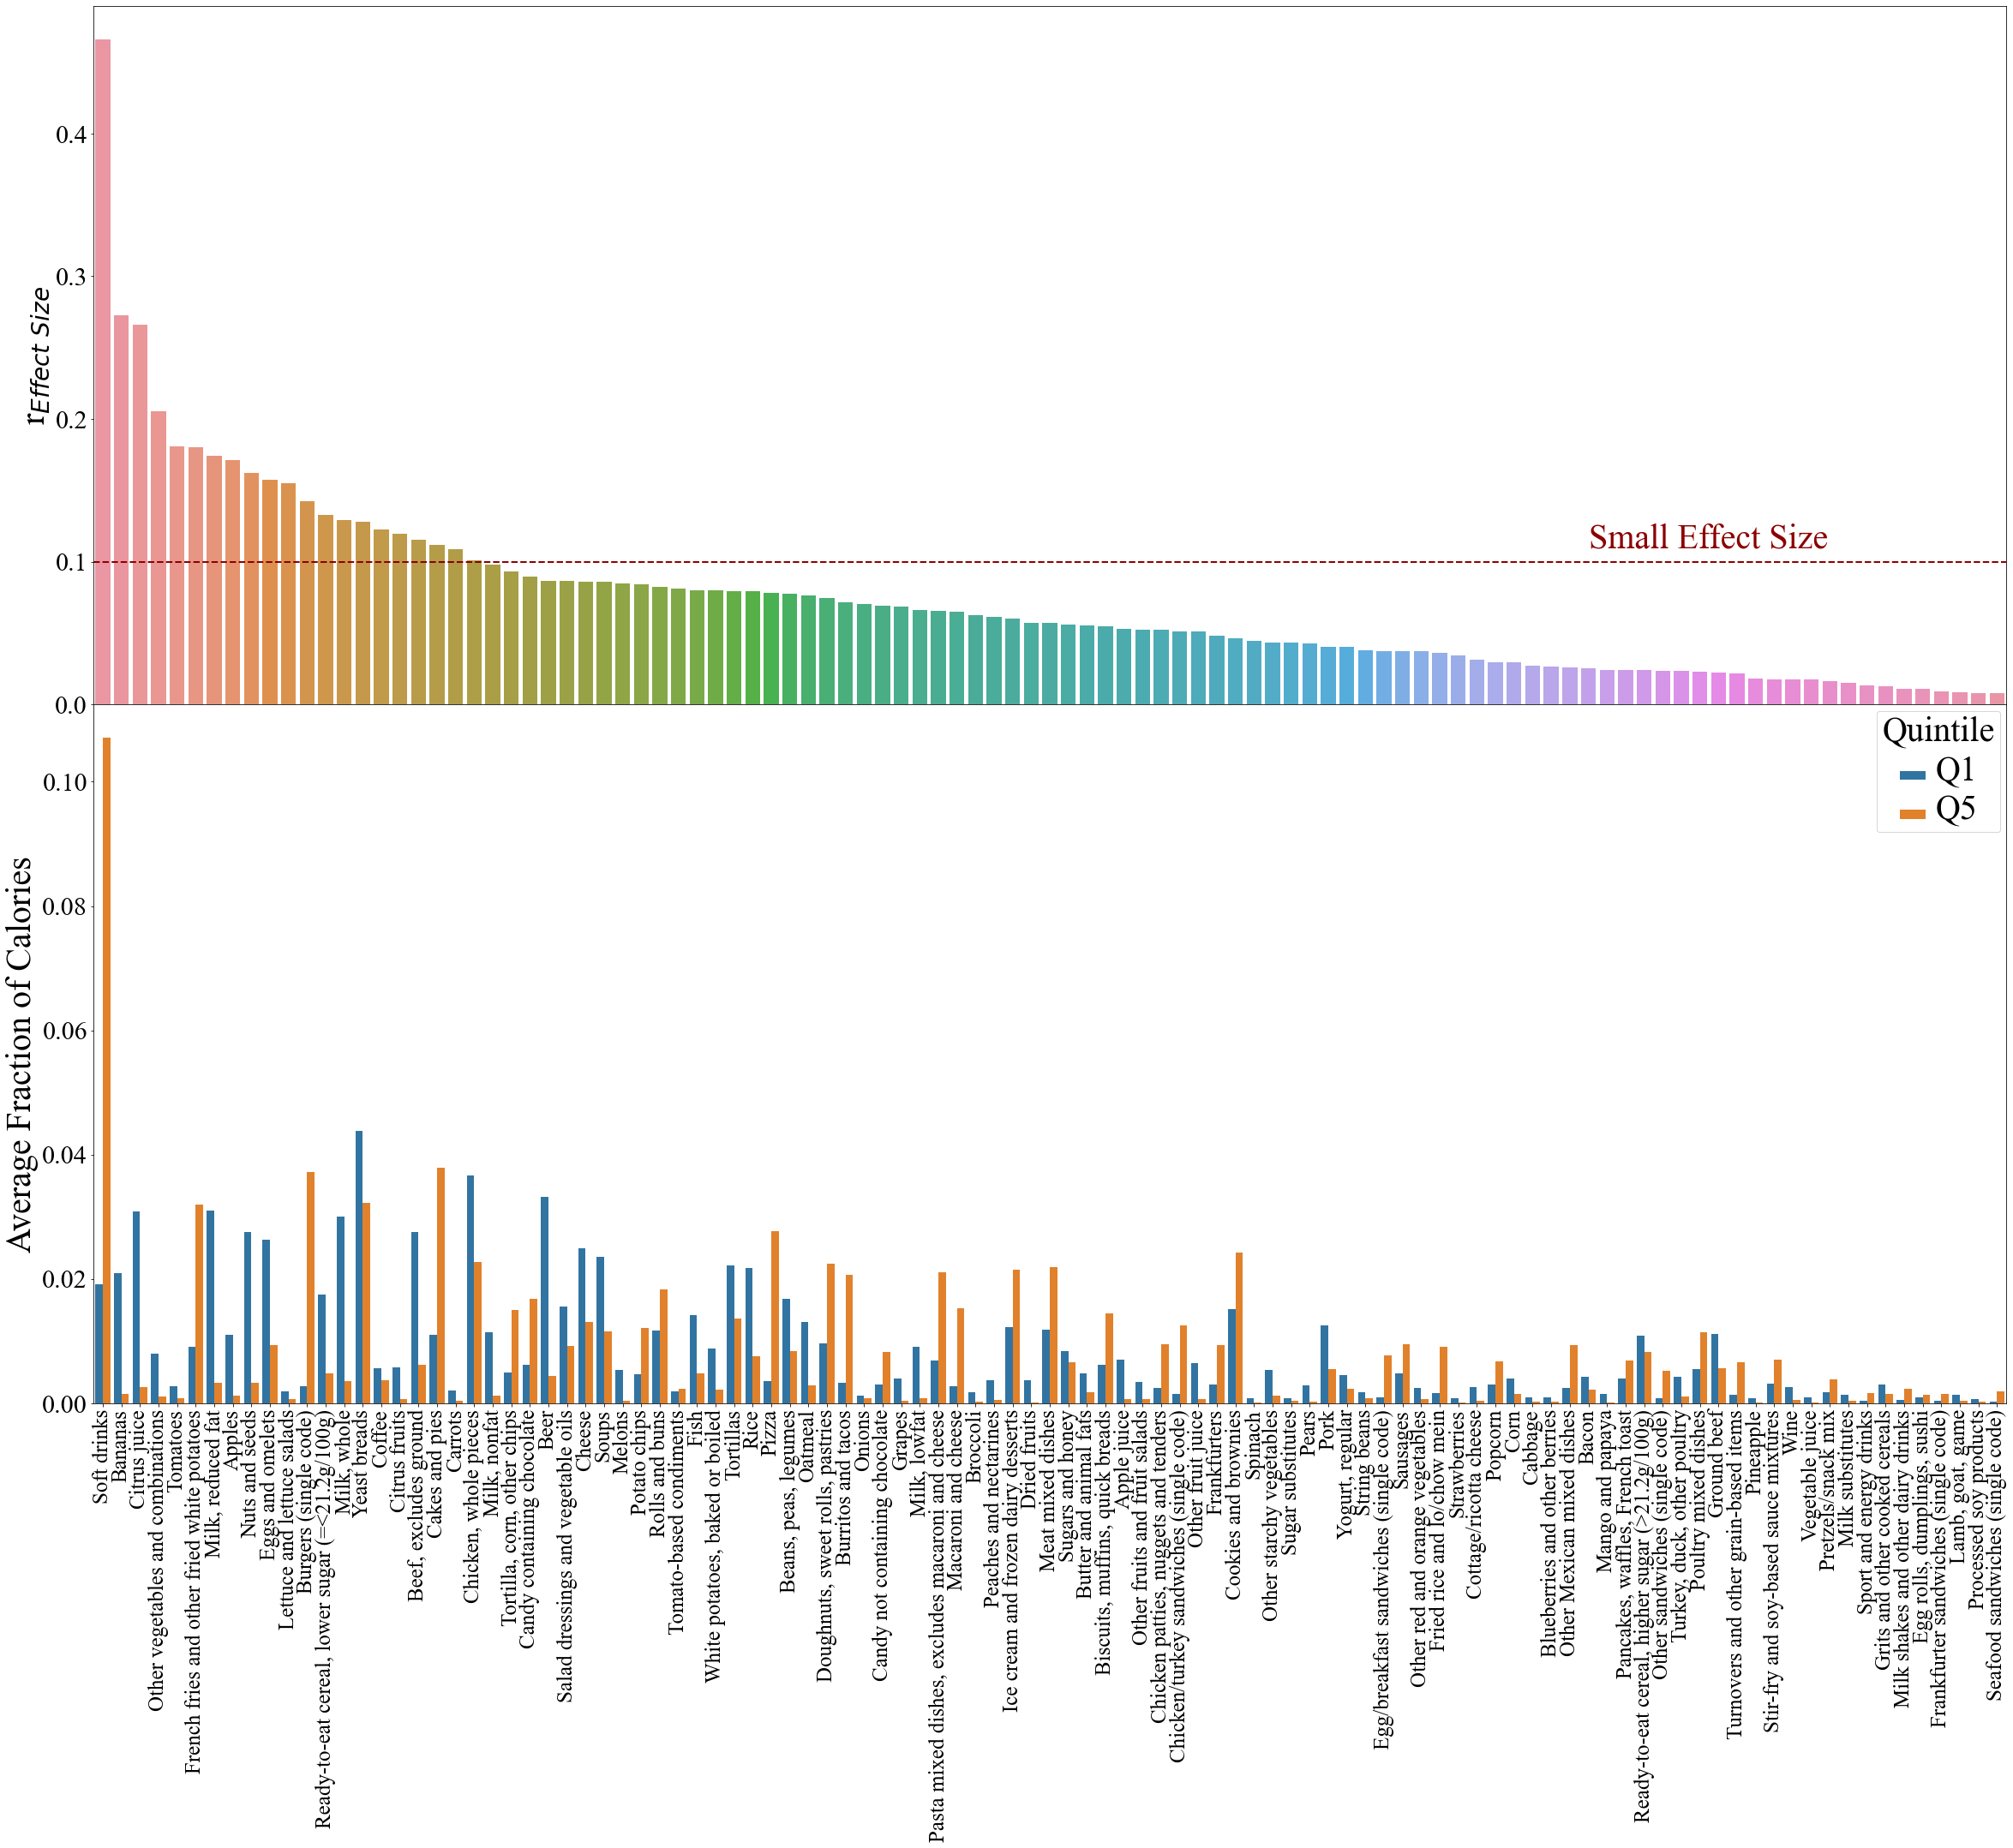

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(40, 30), sharex=True)


sns.barplot(data=dbquantiles2viz, x="WWEIA", y='r_effectsize', ax=axes[0])
axes[0].axhline(0.1, color='darkred',linestyle='dashed', linewidth=2)
axes[0].set_xlabel("")
axes[0].set_ylabel(r"r$_{Effect \ Size}$", fontsize=40)
#plt.setp(ax.get_xticklabels(), fontsize=25)
axes[0].text(80, 0.11, "Small Effect Size", horizontalalignment='left', fontsize=40, color='darkred')
plt.setp(axes[0].get_yticklabels(), fontsize=30)
#plt.setp(axes[0].get_xticklabels(), rotation=90);




p=sns.barplot(data=dbquantiles2viz2, x="WWEIA", y='Average Fraction of Calories', hue='Quintile', ax=axes[1])
plt.setp(p.get_legend().get_texts(), fontsize='40') 
plt.setp(p.get_legend().get_title(), fontsize='40')

axes[1].set_xlabel("")
axes[1].set_ylabel("Average Fraction of Calories", fontsize=40)
plt.setp(axes[1].get_xticklabels(), fontsize=25)
plt.setp(axes[1].get_yticklabels(), fontsize=30)
plt.setp(axes[1].get_xticklabels(), rotation=90);

fig.subplots_adjust(wspace=0, hspace=0)

# Correlation Analysis iFPro vs Consumption of Different Categories

In [34]:
WWEIAlist=list(contrib_tableWWEIA_calories_analyses['WWEIA'].drop_duplicates())
SEQNlist=list(contrib_tableWWEIA_calories_analyses['SEQN'].drop_duplicates())
cat2num={WWEIAlist[n]:n for n in range(len(WWEIAlist))}
SEQN2num={SEQNlist[n]:n for n in range(len(SEQNlist))}

df2corr=contrib_tableWWEIA_calories_analyses[['SEQN', 'FProCalories']].drop_duplicates()
trip_people_WWEIA_FPro=[(num, food, fr) for (num, food, fr) in contrib_tableWWEIA_calories_analyses[['SEQN','WWEIA', 'fraction_calories']].values]

matrixpercalories=np.zeros((len(SEQN2num), len(cat2num)))

for p in trip_people_WWEIA_FPro:
    matrixpercalories[ SEQN2num[p[0]], cat2num[p[1]]]=p[2]

df2corr=pd.concat([df2corr.reset_index(), pd.DataFrame(matrixpercalories,columns=WWEIAlist).reset_index() ], axis=1)
df2corr.drop(columns=['index'], inplace=True)
df2corr.set_index('SEQN', inplace=True)
df2corr=df2corr.loc[:,df2corr.sum()!=0]

corrmatnp=df2corr.corr(method='spearman')

In [35]:
alphav=0.01
dfcorrsel=pd.DataFrame.from_dict({'WWEIA':corrmatnp.columns[1:],
                        'r': [stats.spearmanr(df2corr['FProCalories'], df2corr[w]).correlation for w in corrmatnp.columns[1:]],
                        'pvalue':[stats.spearmanr(df2corr['FProCalories'], df2corr[w]).pvalue for w in corrmatnp.columns[1:]]})



dfcorrsel['BHpvalue']=fdrcorrection(dfcorrsel['pvalue'], alpha=alphav)[1]
dfcorrsel['Bonferroni']=dfcorrsel['pvalue']<(alphav/dfcorrsel.shape[0])

dfcorrsel.sort_values(by=['pvalue'])

,WWEIA,r,pvalue,BHpvalue,Bonferroni
31,Bananas,-0.289862,0.000000e+00,0.000000e+00,True
13,Soft drinks,0.363483,0.000000e+00,0.000000e+00,True
3,Citrus juice,-0.259837,1.172707e-306,6.215346e-305,True
29,Burgers (single code),0.209161,5.198007e-197,2.066208e-195,True
0,Apples,-0.200298,1.666351e-180,5.298995e-179,True
...,...,...,...,...,...
158,"Yogurt, lowfat and nonfat",-0.001294,8.546723e-01,8.748603e-01,False
92,Rice mixed dishes,-0.001261,8.583535e-01,8.748603e-01,False
118,"Pasta sauces, tomato-based",-0.001194,8.657389e-01,8.767674e-01,False
152,"Formula, ready-to-feed",-0.000797,9.101625e-01,9.159230e-01,False


In [36]:
df2visualize=dfcorrsel[dfcorrsel['Bonferroni']].sort_values(by=['r'])
nn=sum(dfcorrsel[dfcorrsel['Bonferroni']]['r']<0)
np=sum(dfcorrsel[dfcorrsel['Bonferroni']]['r']>0)
cmapbarplot={x:y for (x,y) in zip(df2visualize['WWEIA'], [v for v in sns.color_palette('Blues_r', nn)]+[v for v in sns.color_palette('Reds', np)])}

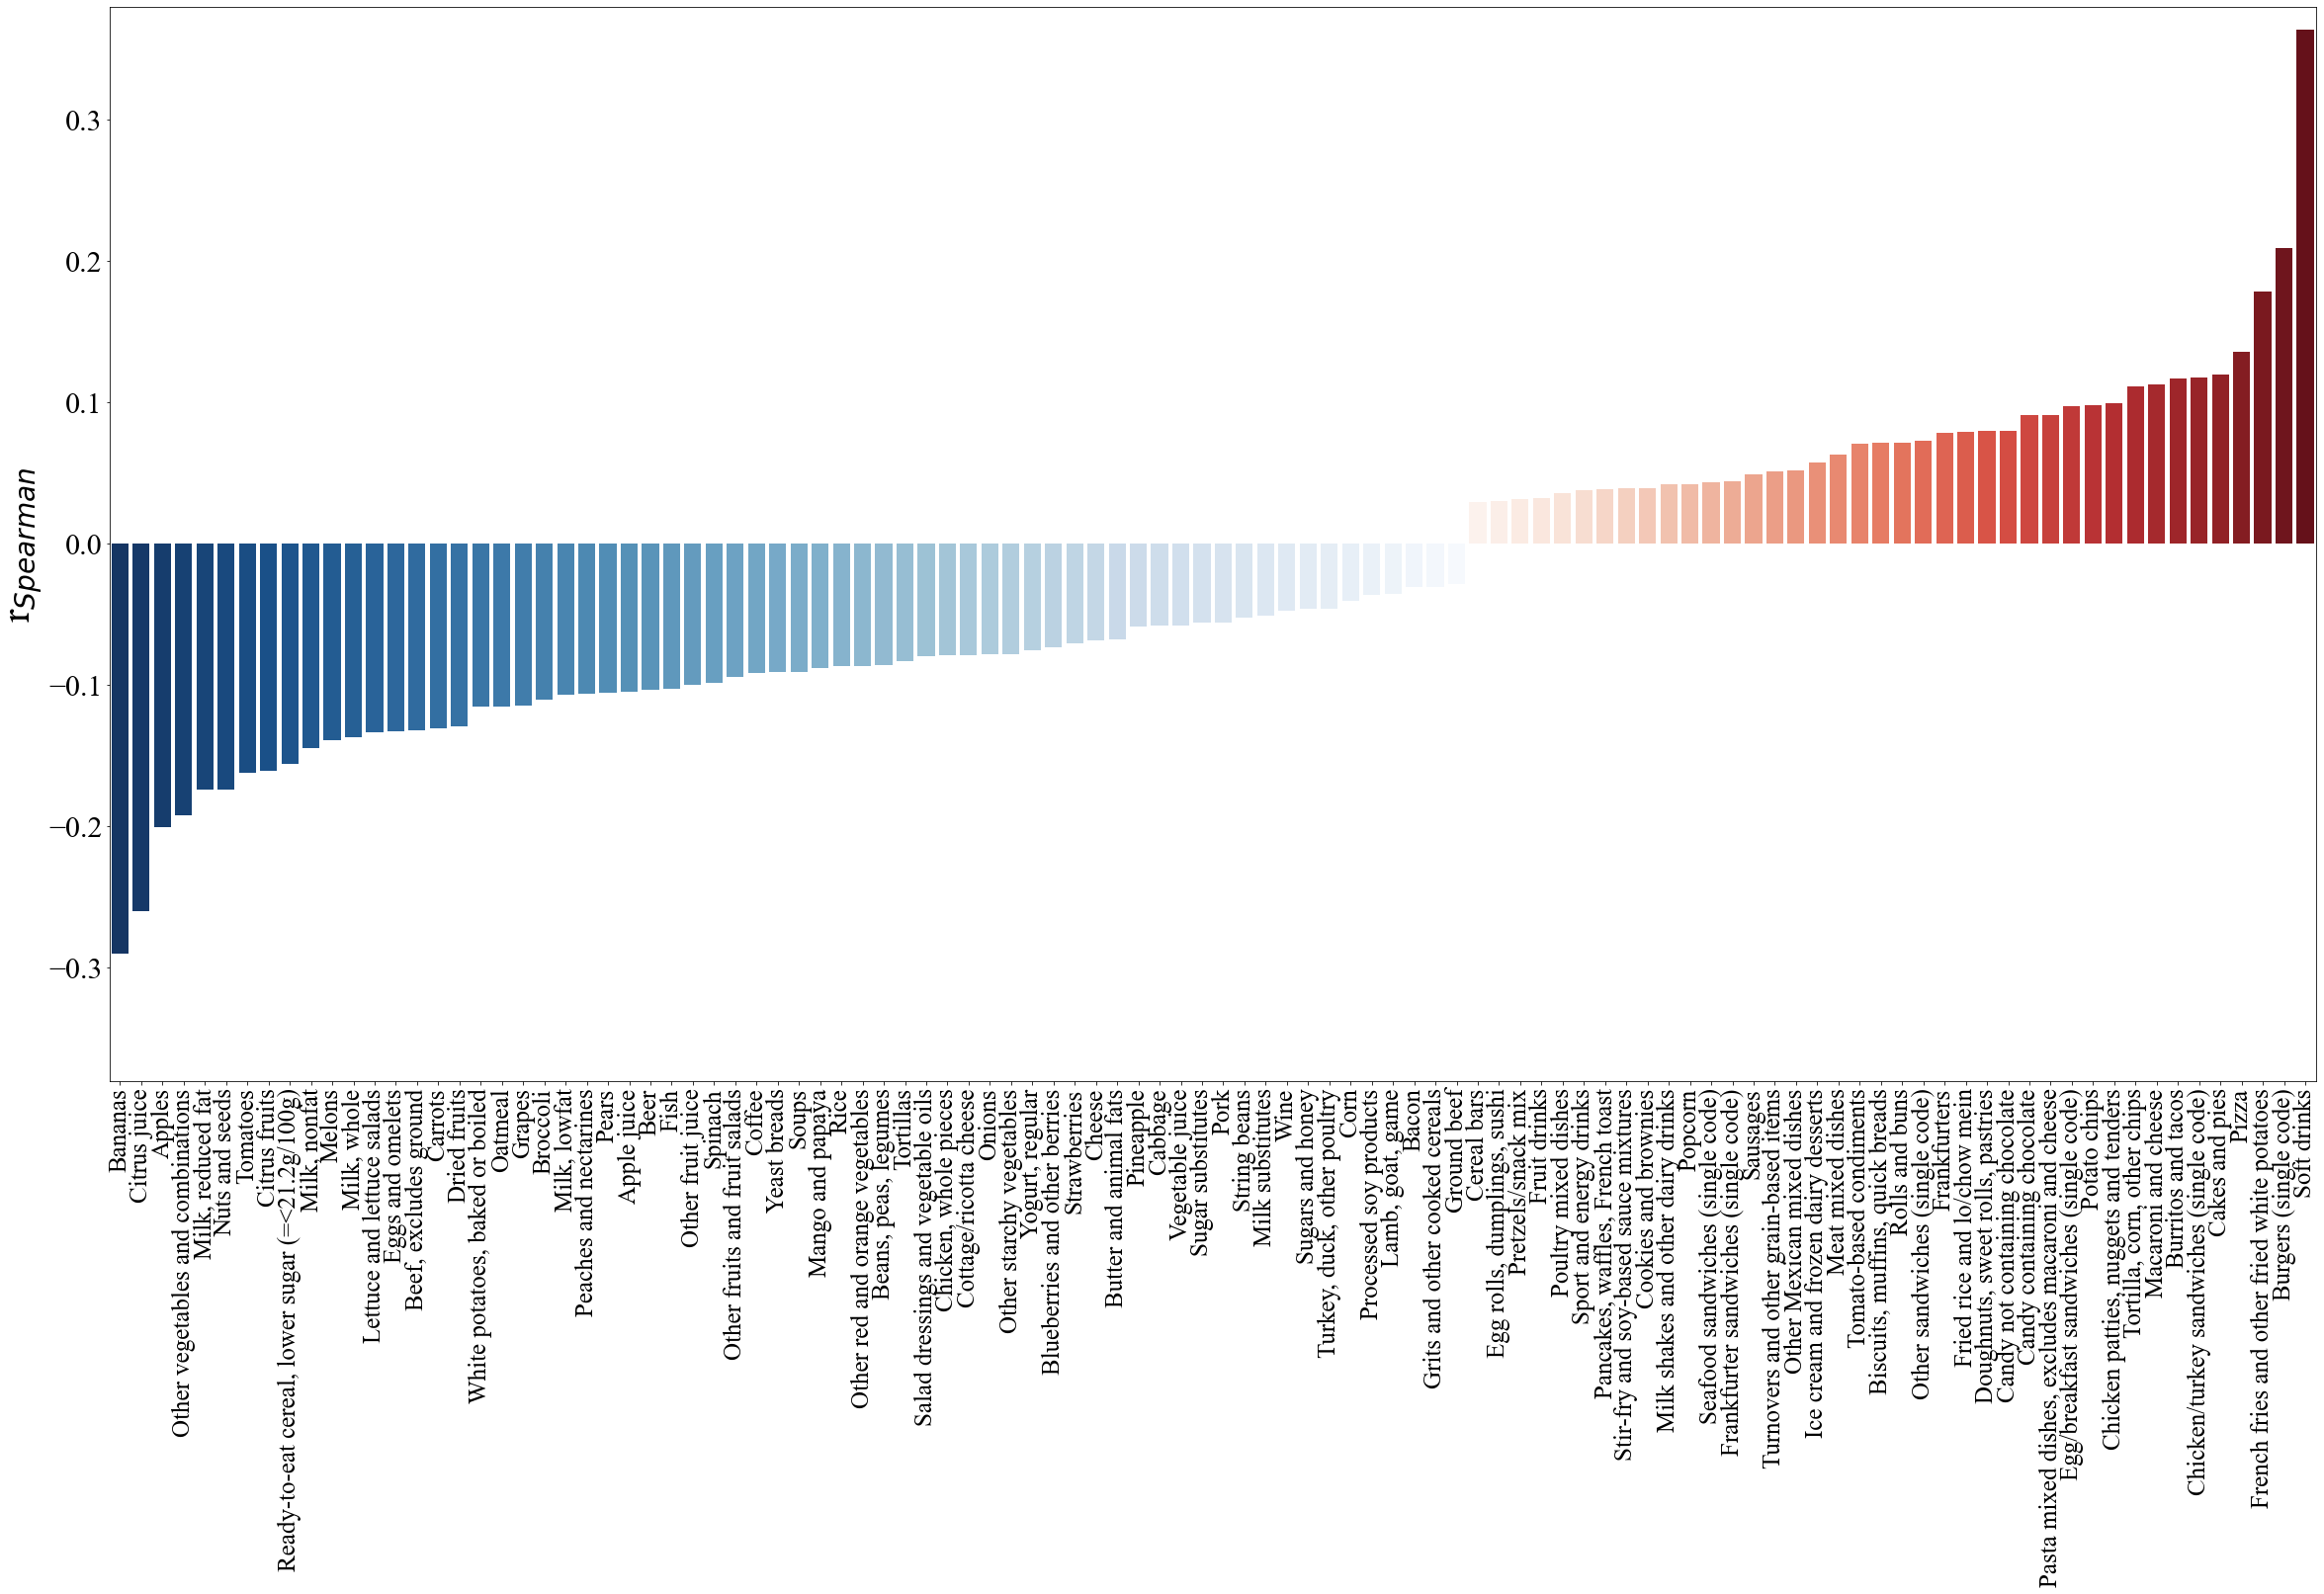

In [37]:
fig, ax = plt.subplots(figsize=(40, 20))
sns.barplot(data=df2visualize, x="WWEIA", y="r", palette=cmapbarplot)
ax.set_xlabel("")
ax.set_ylabel(r"r$_{Spearman}$", fontsize=40)
plt.setp(ax.get_xticklabels(), fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=30)
plt.setp(ax.get_xticklabels(), rotation=90);
ax.set_ylim(-0.38, 0.38);